In [52]:
# import
import cv2
import pickle
import math
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import pyautogui as pg

from time import time, sleep
from tqdm import tqdm
from glob import glob
from pprint import pprint
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from threading import Thread
from matplotlib import pyplot as plt
from line_profiler import LineProfiler

print("OpenCV", cv2.__version__)
print("numpy", np.__version__)
print("pandas", pd.__version__)
print("Pyautogui", pg.__version__)
print("Scikit-learn", sklearn.__version__)


def SaveInstances(instance, path):
    '''
    PickleモジュールのWrapper
    instanceのオブジェクトをpathで指定したファイルパスに保存する。
    '''
    with open(path, mode='wb') as file:
        pickle.dump(instance, file, protocol=2)


def LoadInstances(path):
    '''
    PickleモジュールのWrapper
    pathに保存されているpickle形式のファイルをオブジェクトとして読み込む。
    '''
    with open(path, 'rb') as ins:
        return pickle.load(ins)


OpenCV 4.5.4
numpy 1.20.1
pandas 1.2.4
Pyautogui 0.9.53
Scikit-learn 0.24.1


In [53]:
# assets

class Samples_container:
    imgs_real_part = glob("C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/real/part/*.jpg")
    imgs_color_black = glob("C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/real/color/black/*.jpg")
    imgs_color_white = glob("C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/real/color/white/*.jpg")
    imgs_color_green = glob("C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/real/color/green/*.jpg")
    imgs_color_red = glob("C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/real/color/red/*.jpg")


samples = Samples_container()


In [54]:
# prepare samples of color

def prepare_bgr(paths, code):
    temp = np.reshape([[[[
        [pixel for pixel in line]
        for line in frame]
        for frame in cv2.resize(cv2.imread(path), (640, 360))]
    ]for path in paths
    ], newshape=(-1, 3)
    ).astype(np.int64)
    temp_code = np.ones(len(temp)) * code
    return np.insert(temp, 3, temp_code, axis=1)


color_black = prepare_bgr(samples.imgs_color_black, 1)
color_green = prepare_bgr(samples.imgs_color_green, 2)
color_white = prepare_bgr(samples.imgs_color_white, 3)
color_red = prepare_bgr(samples.imgs_color_red, 4)

color_all = np.concatenate([
    color_black,
    color_green,
    color_white,
    color_red,
])

print("black: {:,}pixels".format(len(color_black)))
print(color_black[:2])
print("green: {:,}pixels".format(len(color_green)))
print(color_green[:2])
print("white: {:,}pixels".format(len(color_white)))
print(color_white[:2])
print("red: {:,}pixels".format(len(color_red)))
print(color_red[:2])


black: 691,200pixels
[[3 3 3 1]
 [3 3 3 1]]
green: 460,800pixels
[[27 89 11  2]
 [29 91 13  2]]
white: 460,800pixels
[[153 173 184   3]
 [155 175 186   3]]
red: 230,400pixels
[[ 16  27 149   4]
 [ 19  30 152   4]]


In [55]:
# color recognizing model

X_train, X_test, y_train, y_test = train_test_split(
    color_all[:, :-1],
    color_all[:, -1:],
    stratify=color_all[:, -1:],  # テストに使うデータを階層化する
    test_size=0.3,  # テストに使う割合
)

col_model = LogisticRegression().fit(X_train, y_train)


C:\Users\Haya\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Haya\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


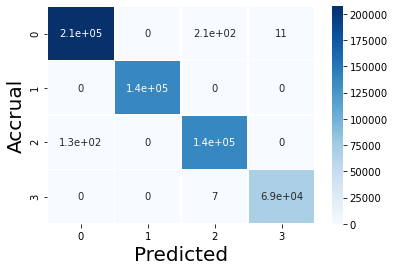

              precision    recall  f1-score   support

           1       1.00      1.00      1.00    207360
           2       1.00      1.00      1.00    138240
           3       1.00      1.00      1.00    138240
           4       1.00      1.00      1.00     69120

    accuracy                           1.00    552960
   macro avg       1.00      1.00      1.00    552960
weighted avg       1.00      1.00      1.00    552960



In [56]:
# color recognizing model

y_pred = col_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, cmap='Blues', linewidth=0.3)
ax.set_xlabel("Predicted", fontsize=20)
ax.set_ylabel("Accrual", fontsize=20)
plt.show()

print(classification_report(y_test, y_pred))


In [57]:
# act decision maker

X_train, X_test, y_train, y_test = train_test_split(
    hoge[:, :-1],
    hoge[:, -1:],
    stratify=hoge[:, -1:],  # テストに使うデータを階層化する
    test_size=0.3,  # テストに使う割合
)

act_model = MLPRegressor(
    hidden_layer_sizes=(4096, 1024, 256, 64, 16)
).fit(

)

y_pred = act_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, cmap='Blues', linewidth=0.3)
ax.set_xlabel("Predicted", fontsize=20)
ax.set_ylabel("Accrual", fontsize=20)
plt.show()

print(classification_report(y_test, y_pred))


NameError: name 'hoge' is not defined